From previous experiments, I will use following features to make prediction on price:

```
other_feature = ['amenities', 'time']
categorical_features = ['region']
numerical_features = ['bathrooms', 'bedrooms', 'square_feet', 'latitude', 'longitude']
```
`amenities` will be vectorized. `time` will be transformed into 5 other features: 'year','month','day','day_of_year','week_of_year'

Considering both performance and execution time, the final model is: **XGBoost**, n_estimators=1500


# Data Preprocessing

In [1]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [2]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
apartment_for_rent_classified = fetch_ucirepo(id=555) 
  
# data (as pandas dataframes) 
df = apartment_for_rent_classified.data.features 

In [3]:
cols_to_numeric = ['bathrooms','bedrooms','price_display','square_feet']
df[cols_to_numeric] = df[cols_to_numeric].apply(pd.to_numeric, errors='coerce')

In [4]:
# function to remove the rows where the count of category value is very low (<=100).
def remove_rows_low_cat_value(df, col):
    
    # Step 1: Get the value counts
    value_counts = df[col].value_counts(dropna=False)

    # Step 2: Identify values with small counts (e.g., counts less than or equal to 100)
    small_count_values = value_counts[value_counts <= 100].index

    # Step 3: Filter out the rows with small count values
    df = df[~df[col].isin(small_count_values)]

    return df

cols_to_filter = ['category', 'currency', 'fee', 'has_photo', 'pets_allowed', 'price_type']
for col in cols_to_filter:
    df = remove_rows_low_cat_value(df,col)

In [5]:
# remove rows where following features contain NaN
cols_not_na = ['price', 'latitude', 'longitude', 'bathrooms', 'bedrooms', 'square_feet', 'state']
for col in cols_not_na:
    df = df[~df[col].isna()]

In [6]:
# filter out extreme outliers
cols_to_filter_extreme_outliers = ['price','square_feet']
for col in cols_to_filter_extreme_outliers:
    upper_limit = df[col].quantile(0.99)
    df = df[df[col] <= upper_limit]

In [7]:
# Drop columns where there is only one uqinue value, or not useful

cols_to_drop = ['category', 'currency', 'price_type', 'price_display']

# Drop the columns in place
df.drop(columns=cols_to_drop, inplace=True)

In [8]:
# Define state to region mapping
state_to_region = {
    'AL': 'Southeast', 'AK': 'West', 'AZ': 'Southwest', 'AR': 'Southeast', 'CA': 'West',
    'CO': 'Southwest', 'CT': 'Northeast', 'DE': 'Southeast', 'FL': 'Southeast', 'GA': 'Southeast',
    'HI': 'West', 'ID': 'West', 'IL': 'Midwest', 'IN': 'Midwest', 'IA': 'Midwest',
    'KS': 'Midwest', 'KY': 'Southeast', 'LA': 'Southeast', 'ME': 'Northeast', 'MD': 'Southeast',
    'MA': 'Northeast', 'MI': 'Midwest', 'MN': 'Midwest', 'MS': 'Southeast', 'MO': 'Midwest',
    'MT': 'West', 'NE': 'Midwest', 'NV': 'West', 'NH': 'Northeast', 'NJ': 'Northeast',
    'NM': 'Southwest', 'NY': 'Northeast', 'NC': 'Southeast', 'ND': 'Midwest', 'OH': 'Midwest',
    'OK': 'Southwest', 'OR': 'West', 'PA': 'Northeast', 'RI': 'Northeast', 'SC': 'Southeast',
    'SD': 'Midwest', 'TN': 'Southeast', 'TX': 'Southwest', 'UT': 'West', 'VT': 'Northeast',
    'VA': 'Southeast', 'WA': 'West', 'WV': 'Southeast', 'WI': 'Midwest', 'WY': 'West',
    'DC': 'Southeast'
}

# Create a new 'region' column
df['region'] = df['state'].map(state_to_region)


In [9]:
df.describe()

,bathrooms,bedrooms,price,square_feet,latitude,longitude,time
count,97297.000000,97297.000000,97297.000000,97297.000000,97297.000000,97297.000000,9.729700e+04
mean,1.424068,1.697524,1469.650524,929.368254,36.962844,-91.426676,1.559607e+09
std,0.515291,0.704209,640.747971,281.291285,4.595735,15.732061,1.101523e+07
min,1.000000,0.000000,100.000000,107.000000,19.573800,-159.369800,1.544174e+09
25%,1.000000,1.000000,1005.000000,726.000000,33.743500,-104.771300,1.550832e+09
50%,1.000000,2.000000,1340.000000,900.000000,37.265800,-84.528900,1.568745e+09
75%,2.000000,2.000000,1758.000000,1102.000000,39.960800,-77.558500,1.568767e+09
max,4.500000,6.000000,4244.000000,2128.000000,64.833200,-68.778800,1.577391e+09


In [10]:
df.describe(include='O')

,title,body,amenities,fee,has_photo,pets_allowed,address,cityname,state,source,region
count,97297,97297,82065,97297,97297,38462,7412,97297,97297,97297,97297
unique,56861,92339,9554,2,3,3,7249,2913,51,25,5
top,Apartment in great location,"When searching for a pet-friendly One-, Two- a...",Parking,No,Yes,"Cats,Dogs",8215 S.W 72nd Avenue,Dallas,TX,RentDigs.com,Southeast
freq,1048,45,6044,97111,54855,36542,19,2851,11145,89321,35415


# Feature Engineering

In [11]:
other_feature = ['amenities', 'time']
categorical_features = ['region']
numerical_features = ['bathrooms', 'bedrooms', 'square_feet', 'latitude', 'longitude']
target = ['price']
data = df[other_feature+categorical_features+numerical_features+target]

In [12]:
from sklearn.feature_extraction.text import CountVectorizer

# Reset index of df first and then concatenate later
data.reset_index(drop=True, inplace=True)

# Fill NaN values with an empty string
data['amenities'] = data['amenities'].fillna('')

# Convert amenities to a format suitable for CountVectorizer
data['amenities_list'] = data['amenities'].apply(lambda x: x.split(','))

# Convert list of amenities back to string format required by CountVectorizer
data['amenities_str'] = data['amenities_list'].apply(lambda x: ' '.join(x))

# Use CountVectorizer to create binary feature matrix
vectorizer = CountVectorizer(tokenizer=lambda x: x.split(), binary=True)
amenities_matrix = vectorizer.fit_transform(data['amenities_str'])

# Convert the binary feature matrix to a DataFrame
amenities_df = pd.DataFrame(amenities_matrix.toarray(), columns=vectorizer.get_feature_names_out())

# Concatenate the original DataFrame with the new binary features DataFrame
data = pd.concat([data, amenities_df], axis=1)

# Drop the original and temporary columns 
data = data.drop(['amenities', 'amenities_list', 'amenities_str'], axis=1)

In [13]:
from sklearn.preprocessing import StandardScaler

# Scaling numerical features
scaler = StandardScaler()
data[numerical_features] = scaler.fit_transform(data[numerical_features])


In [14]:
# One-hot encoding categorical variables
data = pd.get_dummies(data, columns=categorical_features, drop_first=True)

In [15]:

# Convert the Unix timestamp column "time" to datetime
data['time'] = pd.to_datetime(data['time'], unit='s')

# Extract features from datetime
data['year'] = data['time'].dt.year
data['month'] = data['time'].dt.month
data['day'] = data['time'].dt.day
data['day_of_year'] = data['time'].dt.dayofyear
data['week_of_year'] = data['time'].dt.isocalendar().week

data = data.drop(['time'], axis=1)

In [16]:
data

,bathrooms,bedrooms,square_feet,latitude,longitude,price,ac,access,alarm,basketball,...,wood,region_Northeast,region_Southeast,region_Southwest,region_West,year,month,day,day_of_year,week_of_year
0,-0.822971,-0.990512,-1.377114,-0.676901,-1.713022,2195.0,0,0,0,0,...,0,False,False,False,True,2019,12,26,360,52
1,0.147359,1.849567,2.028626,0.026950,0.949186,1250.0,0,0,0,0,...,0,False,True,False,False,2019,12,26,360,52
2,1.117689,1.849567,2.561883,-0.248023,0.812541,1395.0,0,0,0,0,...,0,False,True,False,False,2019,12,26,360,52
3,-0.822971,0.429528,-0.388810,0.304492,-1.941556,1600.0,0,0,0,0,...,0,False,False,False,True,2019,12,26,360,52
4,-0.822971,-0.990512,-1.085600,-0.404517,-0.965188,975.0,0,0,0,0,...,0,False,False,True,False,2019,12,26,360,52
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97292,-0.822971,-0.990512,-1.153146,-1.598826,-0.239838,780.0,0,0,0,0,...,1,False,False,True,False,2018,12,7,341,49
97293,1.117689,0.429528,-0.029750,-1.466029,0.614594,813.0,1,0,0,0,...,0,False,True,False,False,2018,12,7,341,49
97294,-0.822971,-0.990512,-0.993169,-0.919323,-1.631373,1325.0,0,0,0,0,...,0,False,False,False,True,2018,12,7,341,49
97295,-0.822971,-0.990512,-0.811861,-0.336628,0.672616,931.0,0,0,0,0,...,0,False,True,False,False,2018,12,7,341,49


# Model Building

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Splitting data
X = data.drop(['price'], axis=1)
y = data['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [18]:
import xgboost as xgb
# Training the model
model = xgb.XGBRegressor(n_estimators=1500, random_state=42)
model.fit(X_train, y_train)

# Predictions and evaluation
y_pred = model.predict(X_test)
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f'RMSE: {rmse}')

RMSE: 225.76318514530857


# Check feature importance

- feature_importances_: Reflects the average gain (or improvement in accuracy) brought by each feature when it is used in trees across the ensemble.
- plot_importance: By default, it uses the "weight" method, which counts the number of times a feature is used to split the data. It can be changed to "gain" or "cover" to match feature_importances_.

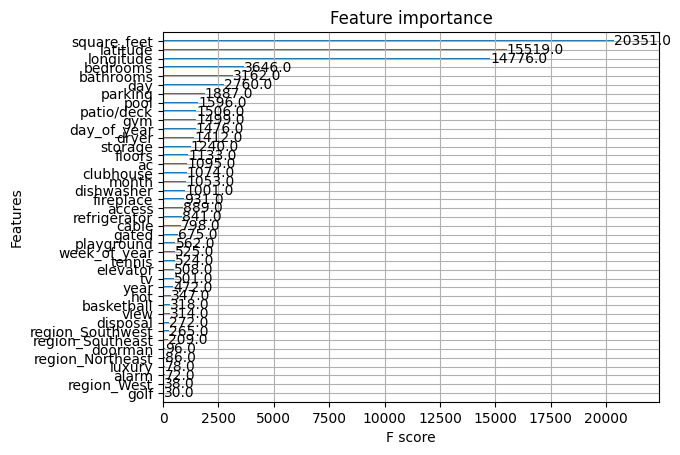

In [19]:
import matplotlib.pyplot as plt

# Plot the feature importances
xgb.plot_importance(model)
plt.show()


The "F score" (also known as the "frequency score") represents the number of times a feature is used to split the data across all trees in the model.

In [20]:
# Assuming `model` is your trained XGBoost model
feature_importances = model.feature_importances_

# Assuming `X_train` is your training DataFrame
feature_importances_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': feature_importances
}).sort_values(by='importance', ascending=False)

print(feature_importances_df)


             feature  importance
4          longitude    0.133845
41  region_Southwest    0.103437
0          bathrooms    0.062332
28        playground    0.057854
3           latitude    0.055435
13           doorman    0.047413
15          elevator    0.038725
2        square_feet    0.035193
46       day_of_year    0.023546
21               gym    0.020763
33            tennis    0.020140
47      week_of_year    0.020001
30      refrigerator    0.019878
42       region_West    0.019814
5                 ac    0.019761
44             month    0.019129
45               day    0.018398
35                tv    0.017684
19             gated    0.017495
43              year    0.015400
17            floors    0.015267
1           bedrooms    0.014662
36              view    0.014206
40  region_Southeast    0.013863
29              pool    0.013842
12          disposal    0.013423
32           storage    0.013186
11        dishwasher    0.013090
6             access    0.012456
26        

<Figure size 1000x800 with 0 Axes>

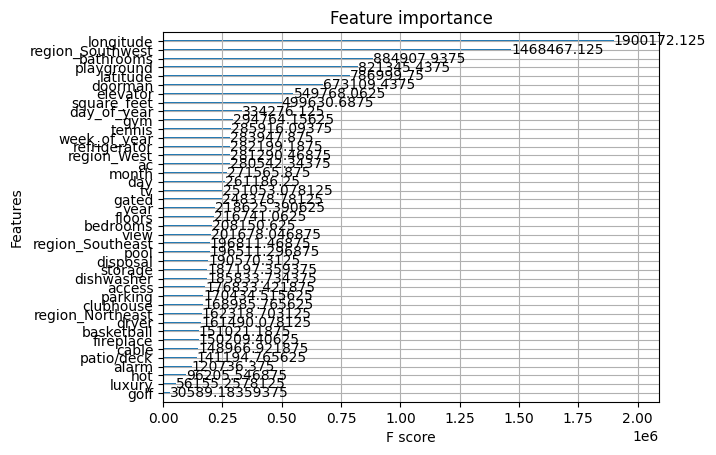

In [39]:
plt.figure(figsize=(10, 8))
xgb.plot_importance(model, importance_type='gain')
plt.show()
